In [290]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
%matplotlib inline

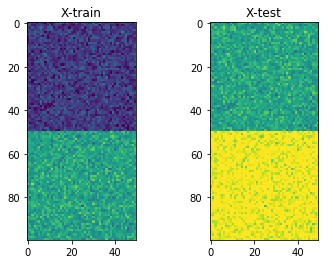

In [237]:
X_train = np.random.normal(0, 1, size=(100, 50))
y_train = np.repeat([0, 1], repeats=50)
X_train[y_train == 1, :] += 5

plt.subplot(1, 2, 1)
plt.imshow(X_train, vmin=-2, vmax=10)
plt.title('X-train')

X_test = X_train.copy() + 5
y_test = y_train.copy()

plt.subplot(1, 2, 2)
plt.imshow(X_test, vmin=-2, vmax=10)
plt.title('X-test')
plt.show()

Estimated mean on train (std): 2.511 (2.663)
Actual mean on test (std): 7.511 (2.663)


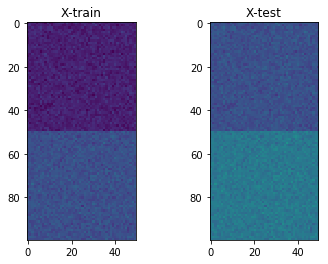

0.5


In [238]:
REFIT = False

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train, y_train)
print("Estimated mean on train (std): %.3f (%.3f)" % (scaler.mean_.mean(), scaler.scale_.mean()))
print("Actual mean on test (std): %.3f (%.3f)" % (X_test.mean(axis=0).mean(), X_test.std(axis=0).mean()))

if REFIT:
    X_test_std = scaler.fit_transform(X_test, y_test)
else:
    X_test_std = scaler.transform(X_test)

plt.subplot(1, 2, 1)
plt.imshow(X_train_std, vmin=-2, vmax=10)
plt.title('X-train')

plt.subplot(1, 2, 2)
plt.imshow(X_test_std, vmin=-2, vmax=10)
plt.title('X-test')
plt.show()

clf.fit(X_train_std, y_train)
preds = clf.predict(X_test_std)
# print(preds)
print(accuracy_score(preds, y_test))

0.261936348934
[  2.61936349e-01  -5.55111512e-18]
0.261936348934


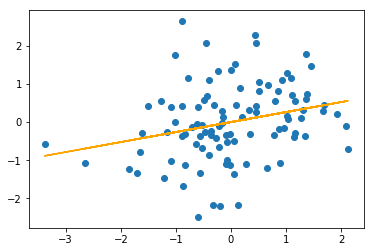

0.0525336097166


In [272]:
intercept = True

y = np.random.normal(0, 1, 100)
y = (y - y.mean()) / y.std()
X = np.random.normal(0, 1, (100, 1))
X = (X - X.mean()) / X.std()

if intercept:
    X = np.c_[X, np.ones(y.size)]

print(pearsonr(y, X[:, 0])[0])

beta = np.linalg.lstsq(X, y)[0]
y_hat = beta[0] * X[:, 0]
print(beta)
print(pearsonr(y_hat, y)[0])

plt.scatter(X[:, 0], y)
plt.plot(X[:, 0], y_hat, c='orange')

plt.show()

skf = RepeatedKFold(n_splits=2, n_repeats=1000)
cv_corr = np.zeros(10000)
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    beta = np.linalg.lstsq(X_train, y_train)[0]
    y_hat = X_test.dot(beta)
    cv_corr[i] = pearsonr(y_hat, y_test)[0]
print(cv_corr.mean())

In [339]:
n_sim = 1000
acc_mean = np.zeros(n_sim)
corrs = np.zeros(n_sim)

y = np.random.normal(0, 1, 100)
X = np.random.normal(0, 1, (100, 1))
X = (X - X.mean()) / X.std()

#y += X.squeeze()
y = (y > np.median(y)).astype(int) 
c = pearsonr(X.squeeze(), y)[0]

if c < 0.1:
    raise ValueError("STOP")
else:
    print("init corr: %.3f" % c)

for i in range(n_sim):

    np.random.shuffle(y)

    kf = RepeatedStratifiedKFold(10, 10)
    corrs[i] = pearsonr(y, X.squeeze())[0]
    
    this_acc = np.zeros(100)
    for ii, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
    
        clf.fit(X_train, y_train)
        this_acc[ii] = clf.score(X_test, y_test)
    acc_mean[i] = this_acc.mean()

init corr: 0.118


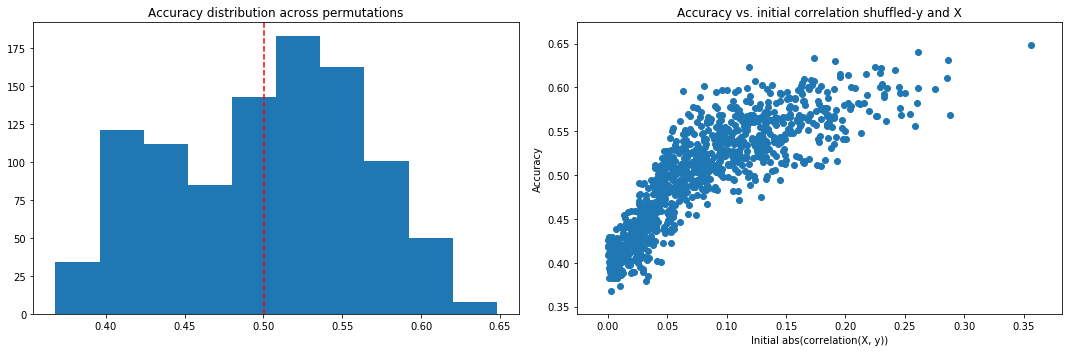

In [343]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(acc_mean)
plt.title("Accuracy distribution across permutations")
plt.axvline(acc_mean.mean(), c='r', ls='--')

plt.subplot(1, 2, 2)
plt.scatter(np.abs(corrs), acc_mean)
plt.title("Accuracy vs. initial correlation shuffled-y and X")
plt.ylabel("Accuracy")
plt.xlabel("Initial abs(correlation(X, y))")
plt.tight_layout()
plt.show()